In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
client_runs   = False

/albedo/home/pscholz/tripyview


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [2]:
# parameters
#___Dask Client Parameters____________________________________________________________
do_papermill      = False
do_parallel       = False
parallel_tnprc    = 128                          # total number of available CPUs
parallel_nprc     = 72                           # number of dask workers
parallel_nprc_bin = parallel_tnprc-parallel_nprc # number of processor used to parallize the binning loop
parallel_tmem     = 200                          # max. available RAM

#___Mesh Path & Save Path_____________________________________________________________
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path         = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path         = None #'~/figures/test_papermill/'
save_fname        = None # filename from papermill come in through save_fname
tripyrun_name     = None # papermill workflow name of notebook 
tripyrun_analysis = None # papermill diagnostic driver
tripyrun_spath_nb = None # papermill path to processed notebooks
tripyrun_spath_fig= None # papermill path to processed figures

#___Data Path & Input Names___________________________________________________________
input_paths   = list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names   = list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

# n_cycl: which spinupcycle should be plottet if do_allcycl all spinupcycles from [1...n_cycle] are plottet, if None path is directly used
n_cycl    = None
do_allcycl= False
vname     = 'nresol'
year      = [1979, 2019]
mon       = None
day       = None
record    = None 
box       = None
depth     = 1000

#___Define Reference Data, Year, Mon ...______________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/'
ref_name  = None # 'TKE'
ref_year  = None #[1979, 2019]
ref_mon   = None
ref_day   = None
ref_record= None

#___Define Climatology________________________________________________________________
which_clim= 'phc3'
clim_path = '/albedo/work/projects/p_fesom/FROM-OLLIE/FESOM2/hydrography/phc3.0/phc3.0_annual.nc'

#___Define Colormap Parameters________________________________________________________
# papermill doesnt like multi variable alignment in a single line
cstr      = 'rygbw'
cnum      = 15
cref      = None
crange    = None
cmin      = None
cmax      = None
cfac      = None
climit    = None
chist     = True
ctresh    = 0.995

ref_cstr  = 'wbgyr'
ref_cnum  = 15
ref_cref  = None
ref_crange= None
ref_cmin  = None
ref_cmax  = None
ref_cfac  = None
ref_climit= None
ref_chist = True
ref_ctresh= 0.995

#___Define Plot Parameters____________________________________________________________
ncol              = 1      # number of pannel columns in figure
nrow              = 1
proj              = 'ortho' 
box               = [-30,45] #[-180, 180, -90, 90]
do_plt            = 'tpc'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = np.unique(np.hstack([np.arange(20,100,5), np.arange(100,200,25)]))   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='bluemarble' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh           = True 
mesh_opt          = dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [3]:
# start parallel dask client
if do_parallel and not client_runs:
    from dask.distributed import Client
    ##import dask
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client_runs = True
    client

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

# #______________________________________________________________________________________________________
# if (n_cycl is not None): 
#     cycl_s=1 if do_allcycl else n_cycl
#     #__________________________________________________________________________________________________
#     aux_path, aux_name = list(), list()
#     input_paths_old, input_names_old = input_paths, input_names
#     for ii, (ipath,iname) in enumerate(zip(input_paths,input_names)):
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ipath,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(iname))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, iname))
#             print(ii, aux_path[-1],aux_name[-1])
#     input_paths, input_names = aux_path, aux_name
    
#     #__________________________________________________________________________________________________
#     if (ref_path is not None): 
#         aux_path, aux_name = list(), list()
#         ref_path_old, ref_name_old = ref_path, ref_name
#         for ii_cycl in range(cycl_s, n_cycl+1):
#             aux_path.append(os.path.join(ref_path,'{:d}/'.format(ii_cycl)))
#             if not do_allcycl: aux_name.append('{}'.format(ref_name))
#             else             : aux_name.append('{:d}) {}'.format(ii_cycl, ref_name))
#             print('R', ref_path[-1])        
#         ref_path, ref_name = aux_path, aux_name
#     del(aux_path, aux_name)  

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
# ref_cinfo=None
# if (ref_path != None): 
#     if ref_year   is None: ref_year   = year
#     if ref_mon    is None: ref_mon    = mon
#     if ref_record is None: ref_record = record
#     cinfo['cref']=0.0 
#     ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)
    
# #______________________________________________________________________________________________________    
# # concatenate list = list1+list2
# if (ref_path != None): 
#     if isinstance(ref_path, list): 
#         input_paths, input_names = ref_path + input_paths        , ref_name + input_names
#     else:    
#         input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


nresol
 > comp n_resol from n_area
--> histo: cmin, cmax =  14.488873645617122 141.3282724351472
[ 20  25  30  35  40  45  50  55  60  65  70  75  80  85  90  95 100 125
 150 175] None
{'cstr': 'rygbw', 'cnum': 15, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': 14.49, 'cmax': 141.33, 'cref': 65, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fa8657e0280>, 'clevel': array([ 20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,
        85,  90,  95, 100, 125, 150, 175]), 'clab': array([ 25,  30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,
        90,  95, 100, 125, 150])}


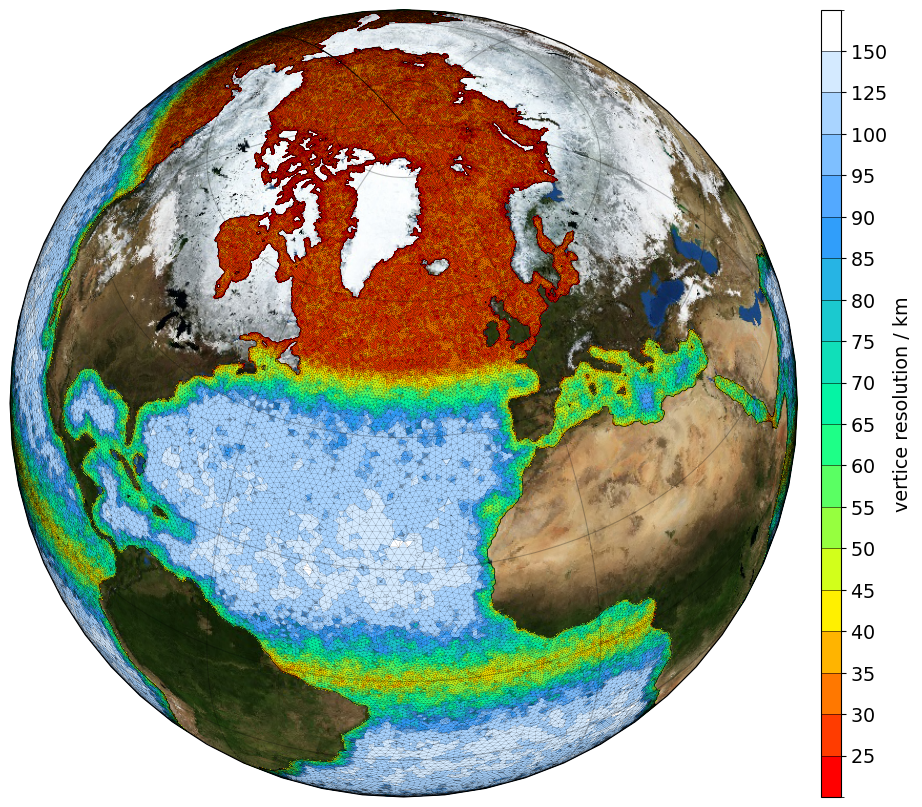

In [5]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
ndat   = 1
if   ncol != None: 
    ncol0  = np.min([ncol,ndat])    
    nrow0  = np.ceil(ndat/ncol0).astype('int')
elif nrow != None: 
    nrow0  = np.min([nrow,ndat])    
    ncol0  = np.ceil(ndat/nrow0).astype('int')
svname = vname

#______________________________________________________________________________________________________
# do save filename path
spath  = save_path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}.{:s}'.format(svname, proj, sfmt)) )
if save_fname!=None: sfpath = [save_fname] # --> needed for diagrun papermille functionality

#______________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 

    
if do_lsm=='bluemarble' and vname=="None": 
    if mesh_opt['color']=='k' or mesh_opt['color']=='black': mesh_opt.update({'color':'w','linewidth':np.max([0.20,mesh_opt['linewidth']])})    
        
#__________________________________________________________________________________________________
hfig, hax, hcb = tpv.plot_hmesh(mesh, vname, cinfo=cinfo0, box=box, nrow=nrow0, ncol=ncol0, proj=proj, do_rescale=do_rescale, 
                                do_mesh=do_mesh, mesh_opt=mesh_opt, do_lsm=do_lsm, 
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':5.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi)  